In [118]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext.transforms as T
from torch import optim
from torch.utils.data import DataLoader
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas.nlp import NlpContext
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.common.utils.text import is_corpus_title, is_longer_text
from torchlake.text_classification.datasets.ag_news.constants import \
    CLASS_NAMES as AG_NEWS_CLASS_NAMES
from torchlake.text_classification.models.rcnn import RCNN
from torchlake.common.utils.text import build_vocab
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import AG_NEWS

# setting


In [119]:
DATASET_NAME = "AGNews"

In [120]:
artifact_path = Path('../../artifacts/rcnn-text-classification')
data_path = Path('../../data') / DATASET_NAME

In [121]:
NUM_CLASS = len(AG_NEWS_CLASS_NAMES)

In [122]:
CONTEXT = NlpContext(max_seq_len=256)

In [123]:
BATCH_SIZE = 128
MINIMUM_LENGTH = 5

In [124]:
DEVICE = torch.device(CONTEXT.device)

In [125]:
tokenizer = get_tokenizer('basic_english')

In [126]:
def datapipe_factory(
    datapipe,
    minimum_length: int = 1,
    transform=None,
):
    datapipe = (
        datapipe.map(lambda pair: (pair[0], pair[1].strip())) # label, text
        .map(lambda pair: (pair[0], pair[1].lower()))
        .filter(lambda pair: is_longer_text(pair[1], minimum_length))
        .filter(lambda pair: not is_corpus_title(pair[1]))
        .map(lambda pair: (pair[0], tokenizer(pair[1])))
    )  

    if transform:
        datapipe = datapipe.map(
            lambda pair: (
                transform(pair[1]),
                pair[0] - 1,
            )  # tokens, label
        )

    return datapipe

In [127]:
train_datapipe, test_datapipe = AG_NEWS(data_path.as_posix())

In [128]:
vocab = build_vocab(
    map(lambda pair: pair[1], datapipe_factory(train_datapipe)),
    context=NlpContext(),
)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [129]:
VOCAB_SIZE = len(vocab)

In [130]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [131]:
train_datapipe = datapipe_factory(
    train_datapipe,
    MINIMUM_LENGTH,
    text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    MINIMUM_LENGTH,
    text_transform,
)

In [132]:
count = 0
for text, label in train_datapipe:
    print(text.shape)
    print(label)
    if count > 10:
        break
    count+=1

torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2
torch.Size([256])
2


In [133]:
NUM_WORKERS = get_num_workers()

In [134]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=NUM_WORKERS,
)

In [135]:
count = 0
for text, label in train_dataloader:
    print(text.shape)
    print(label.shape)
    if count > 10:
        break
    count+=1

torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])


d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "


torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])
torch.Size([128, 256])
torch.Size([128])


# training


In [136]:
EMBED_DIM = 300
HIDDEN_DIM = 128

In [137]:
EPOCHS = 10
ACC_ITERS = max(1, 32 / BATCH_SIZE)
LR = 1e-3

In [138]:
trainer = ClassificationTrainer(EPOCHS, DEVICE, ACC_ITERS)

In [139]:
model = RCNN(
    VOCAB_SIZE,
    EMBED_DIM,
    HIDDEN_DIM,
    NUM_CLASS,
    context=CONTEXT,
).to(DEVICE)

In [140]:
loss = trainer.get_criterion(NUM_CLASS)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [141]:
torchinfo.summary(model)

Layer (type:depth-idx)                        Param #
Rcnn                                          --
├─SequenceModelFullFeatureExtractor: 1-1      --
│    └─Embedding: 2-1                         9,100,500
│    └─ModuleList: 2-2                        --
│    │    └─RNN: 3-1                          110,080
├─Conv1d: 1-2                                 71,296
├─Linear: 1-3                                 516
Total params: 9,282,392
Trainable params: 9,282,392
Non-trainable params: 0

In [142]:
training_loss = trainer.run(train_dataloader, model, optimizer, loss)

938it [00:56, 16.64it/s]


epoch 1 : 0.0037612016944835584


938it [00:51, 18.25it/s]


epoch 2 : 0.0019729302361607554


938it [00:50, 18.64it/s]


epoch 3 : 0.0015257669110782445


938it [00:50, 18.58it/s]


epoch 4 : 0.0012089951860097547


938it [00:50, 18.70it/s]


epoch 5 : 0.0009542696892749518


938it [00:49, 18.76it/s]


epoch 6 : 0.0007306478816550225


938it [00:50, 18.49it/s]


epoch 7 : 0.000548900315274174


938it [00:50, 18.65it/s]


epoch 8 : 0.00042023257348143187


938it [00:50, 18.62it/s]


epoch 9 : 0.0003378057519420205


938it [00:51, 18.05it/s]

epoch 10 : 0.00028456061495429213


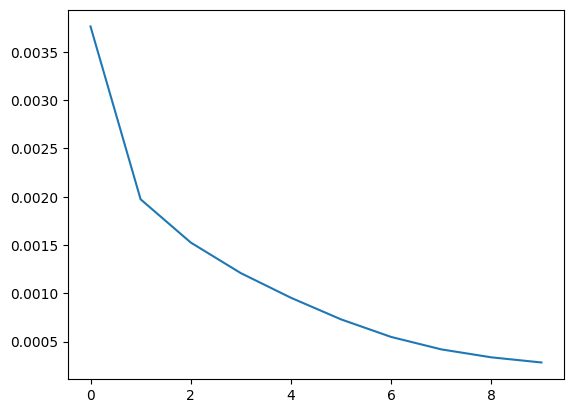

In [143]:
plt.plot(training_loss)

# Inference

In [144]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE, feature_dim=-1)

In [145]:
confusion_matrix = evaluator.run(iter(test_dataloader), model)

59it [00:03, 18.15it/s]

[[1696   39   91   39]
 [  27 1815   25    4]
 [  71   14 1687  111]
 [  82   18  236 1517]]


In [146]:
per_class_acc = evaluator.get_per_class_accuracy(confusion_matrix)
evaluator.show_per_class_accuracy(AG_NEWS_CLASS_NAMES, per_class_acc)

world     : 0.9093833780160858
sports    : 0.9700694815606627
business  : 0.895910780669145
science   : 0.8186724230976794


In [147]:
per_class_acc.mean()

0.8985090158358933

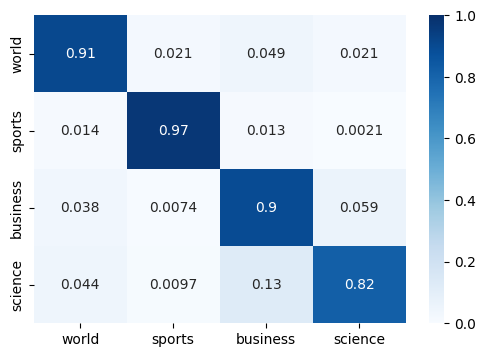

In [148]:
evaluator.plot_confusion_matrix(
    confusion_matrix,
    AG_NEWS_CLASS_NAMES,
    "Blues",
    annot=True,
    figsize=(6, 4),
)

# File


In [149]:
model_path = artifact_path / "rcnn.pth"

In [150]:
torch.save(model.state_dict(), model_path)

In [151]:
get_file_size(model_path)

'35.41MB'

In [152]:
model.load_state_dict(torch.load(model_path.as_posix()))

<All keys matched successfully>